In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/Users/neeleshkarthikeyan/Work/Waste Classification/dataset"
test_path = os.path.join(data_dir, 'test')
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')

img_dim = 224
batch_size = 32
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)  

training_set = train_datagen.flow_from_directory(train_path, target_size = (img_dim, img_dim), batch_size = batch_size,class_mode = 'binary')
val_set = test_datagen.flow_from_directory(val_path, target_size = (img_dim, img_dim), batch_size = batch_size, class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_path, target_size = (img_dim, img_dim), batch_size = batch_size, class_mode = 'binary', shuffle=False)
    
model_dict = dict()
result_dict = dict()
history_dict = dict()

Found 15602 images belonging to 2 classes.
Found 1950 images belonging to 2 classes.
Found 1950 images belonging to 2 classes.


In [6]:
def plot_results(history):
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(constrained_layout=True, figsize=(18,10))
        specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

        ax1 = fig.add_subplot(specs[0, 0]) # First Row First Column
        ax2 = fig.add_subplot(specs[0, 1]) # First Row Second Column

        # First Plot
        ax1.set_title("Training and Validation Accuracy", fontsize=14)
        ax1.plot(history.history["accuracy"], "blue", label="Training")
        ax1.plot(history.history["val_accuracy"], "red", label="Validation")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.minorticks_on()
        ax1.grid(color='w', linestyle='solid')

        # Second Plot
        ax2.set_title("Training and Validation Loss", fontsize=14)
        ax2.plot(history.history["loss"], "blue", label="Training")
        ax2.plot(history.history["val_loss"], "red", label="Validation")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Loss")
        ax2.legend()
        ax2.minorticks_on()
        ax2.grid(color='w', linestyle='solid')

    plt.show()
    

def model_evaluation(model, test_set): 
    predictions = model.predict_generator(test_set)
    predictions[predictions <= 0.5] = 0
    predictions[predictions > 0.5] = 1

    accuracy = round(accuracy_score(test_set.classes,predictions), 6)
    precision = round(precision_score(test_set.classes,predictions), 6)
    recall = round(recall_score(test_set.classes,predictions), 6)
    f1 = round(f1_score(test_set.classes,predictions), 6)
    
    fpr, tpr, thresholds = roc_curve(test_set.classes,predictions)
    roc_auc = auc(fpr, tpr)
    
    print(confusion_matrix(test_set.classes,predictions))
    print("accuracy_score :", accuracy)
    print("precision_score :", precision)
    print("recall_score :", recall)
    print("f1 :", f1)
    print("auc :", roc_auc)
    
    return [accuracy, precision, recall, f1, roc_auc]


def get_activation_func(activation_func):
    if activation_func == "ReLU":
        return ReLU(max_value=None, negative_slope=0, threshold=0)
    
    elif activation_func == "LeakyReLU":
        return LeakyReLU(alpha=0.3)
    
    elif activation_func == "ELU":
        return ELU(alpha=1.0)

    
def get_optimizer(optimizer_func):
    if optimizer_func == "SGD":
        return SGD()
    
    elif optimizer_func == "RMSprop":
        return RMSprop()
    
    elif optimizer_func == "Adam":
        return Adam()   

    
def transfer_learning_model(pre_trained_model, img_dim, kt_units, kt_activation_func, kt_dropout, kt_lr):
    epochs = 1

    # Make all the layers in the pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False
        
    x = layers.Dropout(kt_dropout)(pre_trained_model.output)
    x = layers.Flatten()(x)
    x = layers.Dropout(kt_dropout)(x)
    x = layers.Dense(kt_units, activation=kt_activation_func)(x)
    x = layers.Dense(1, activation='sigmoid')(x)           
    
    model = Model(pre_trained_model.input, x) 
    callback = EarlyStopping(monitor='loss', patience=3)
    
    model.compile(optimizer = Adam(learning_rate=kt_lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
    history = model.fit_generator(training_set, steps_per_epoch=len(training_set), epochs=epochs, callbacks=[callback], validation_data=val_set, validation_steps=len(val_set))
    
    model.save('NASNetMobile')
    
    return model, history   


def assign_kt_hyperparameters(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    activation = hp.Choice("activation", ["relu", "tanh", "selu", "elu"])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    print(units, activation, dropout, lr)
    
    return units, activation, dropout, lr


def assign_hyperparameters():
    units = 128
    activation = ELU(alpha=1.0)
    dropout = 0.5
    lr = 0.001
    
    return units, activation, dropout, lr


<h3>Transfer Learning Models</h3>

- DenseNet121
- InceptionResNetV2
- Xception
- ResNet152V2
- InceptionV3
- DenseNet201
- ResNet101V2
- MobileNetV2
- ResNet50V2 
- VGG19

In [7]:
def training_main(pre_trained_model, model_name, img_dim):

    # Assigning hyper-paramters
    units, activation_func, dropout, lr = assign_hyperparameters()

    # Model Training 
    model_dict[model_name], history_dict[model_name] = transfer_learning_model(pre_trained_model, img_dim, units, activation_func, dropout, lr)
    
    # Plotting training and validation 
    plot_results(history_dict[model_name])
    
    # Model evaluation on test_set
    result_dict[model_name] = model_evaluation(model_dict[model_name], test_set)


---

Metal device set to: Apple M1


2021-12-16 11:16:45.428270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-16 11:16:45.428501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-16 11:16:46.718085: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-16 11:16:46.718915: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-12-16 11:16:47.997921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - ETA: 0s - loss: 0.3947 - accuracy: 0.8577

2021-12-16 11:17:25.213224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - 43s 83ms/step - loss: 0.3947 - accuracy: 0.8577 - val_loss: 0.3413 - val_accuracy: 0.8528
Epoch 2/10
488/488 [==============================] - 36s 74ms/step - loss: 0.2520 - accuracy: 0.8948 - val_loss: 0.3097 - val_accuracy: 0.8662
Epoch 3/10
488/488 [==============================] - 39s 80ms/step - loss: 0.2214 - accuracy: 0.9077 - val_loss: 0.2903 - val_accuracy: 0.8774
Epoch 4/10
488/488 [==============================] - 41s 85ms/step - loss: 0.2075 - accuracy: 0.9160 - val_loss: 0.2837 - val_accuracy: 0.8877
Epoch 5/10
488/488 [==============================] - 43s 88ms/step - loss: 0.1888 - accuracy: 0.9239 - val_loss: 0.2793 - val_accuracy: 0.8867
Epoch 6/10
488/488 [==============================] - 43s 89ms/step - loss: 0.1830 - accuracy: 0.9264 - val_loss: 0.2741 - val_accuracy: 0.8826
Epoch 7/10
488/488 [==============================] - 44s 90ms/step - loss: 0.1738 - accuracy: 0.9310 - val_loss: 0.2786 - val_accuracy: 0.8841
Epo

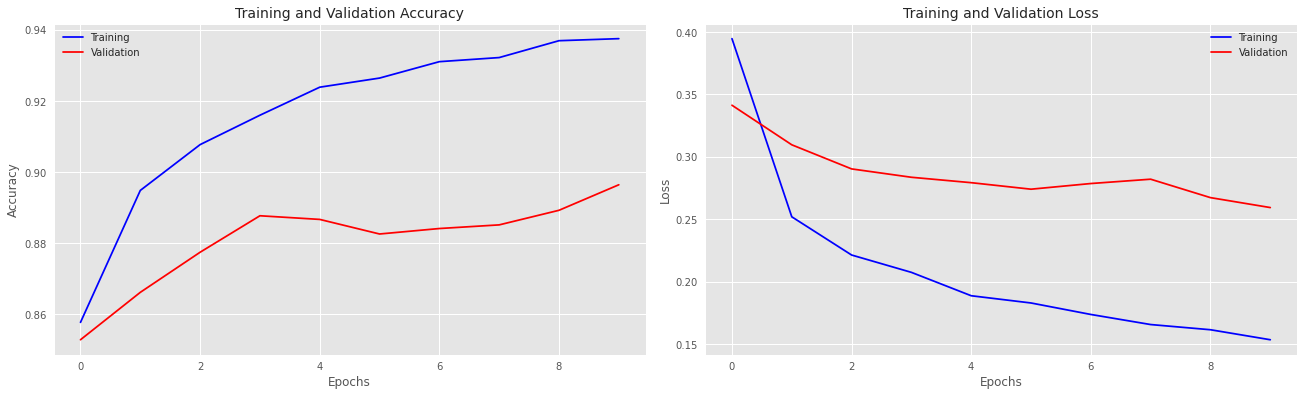

2021-12-16 11:23:50.668927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[891  84]
 [ 50 925]]
accuracy_score : 0.931282
precision_score : 0.916749
recall_score : 0.948718
f1 : 0.93246
auc : 0.9312820512820513


In [4]:
from tensorflow.keras.applications.densenet import DenseNet121
pre_trained_model_1 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

training_main(pre_trained_model_1, "DenseNet121", img_dim)

Epoch 1/10


2021-12-16 11:38:11.741855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - ETA: 0s - loss: 0.4381 - accuracy: 0.8246

2021-12-16 11:39:12.948356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - 74s 143ms/step - loss: 0.4381 - accuracy: 0.8246 - val_loss: 0.4684 - val_accuracy: 0.7841
Epoch 2/10
488/488 [==============================] - 65s 132ms/step - loss: 0.3236 - accuracy: 0.8585 - val_loss: 0.4116 - val_accuracy: 0.8292
Epoch 3/10
488/488 [==============================] - 67s 138ms/step - loss: 0.3025 - accuracy: 0.8684 - val_loss: 0.3990 - val_accuracy: 0.8221
Epoch 4/10
488/488 [==============================] - 71s 144ms/step - loss: 0.2898 - accuracy: 0.8732 - val_loss: 0.3725 - val_accuracy: 0.8400
Epoch 5/10
488/488 [==============================] - 76s 155ms/step - loss: 0.2747 - accuracy: 0.8771 - val_loss: 0.3593 - val_accuracy: 0.8410
Epoch 6/10
488/488 [==============================] - 78s 160ms/step - loss: 0.2686 - accuracy: 0.8847 - val_loss: 0.3823 - val_accuracy: 0.8467
Epoch 7/10
488/488 [==============================] - 80s 163ms/step - loss: 0.2556 - accuracy: 0.8855 - val_loss: 0.3521 - val_accuracy: 0.8

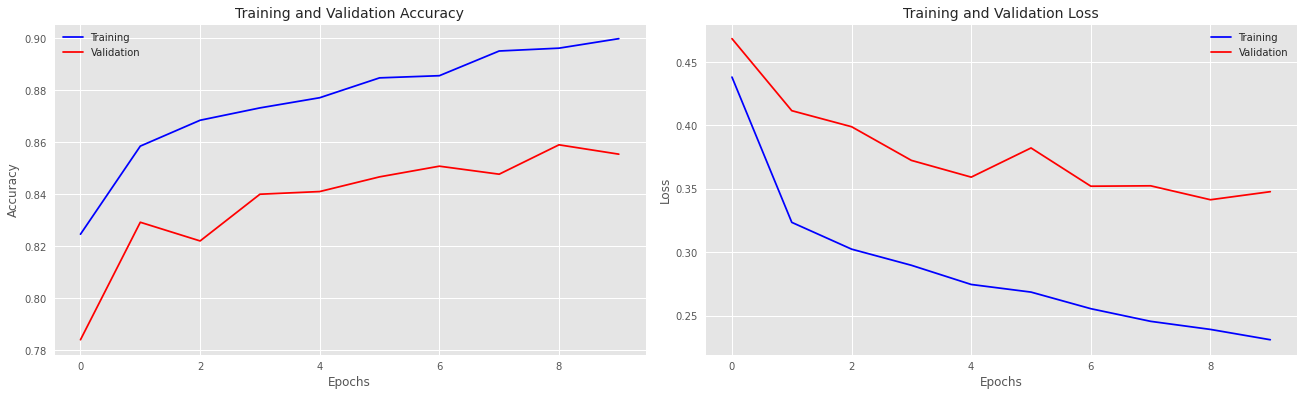

2021-12-16 11:50:36.403752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[823 152]
 [ 51 924]]
accuracy_score : 0.895897
precision_score : 0.858736
recall_score : 0.947692
f1 : 0.901024
auc : 0.895897435897436


In [5]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
pre_trained_model_2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

training_main(pre_trained_model_2, "InceptionResNetV2", img_dim)

Epoch 1/10


2021-12-16 11:56:28.274148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8767

2021-12-16 11:57:13.223387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - 51s 103ms/step - loss: 0.3241 - accuracy: 0.8767 - val_loss: 0.3485 - val_accuracy: 0.8462
Epoch 2/10
488/488 [==============================] - 50s 101ms/step - loss: 0.2301 - accuracy: 0.9131 - val_loss: 0.3363 - val_accuracy: 0.8626
Epoch 3/10
488/488 [==============================] - 55s 113ms/step - loss: 0.2010 - accuracy: 0.9201 - val_loss: 0.3290 - val_accuracy: 0.8692
Epoch 4/10
488/488 [==============================] - 59s 121ms/step - loss: 0.1822 - accuracy: 0.9244 - val_loss: 0.3068 - val_accuracy: 0.8733
Epoch 5/10
488/488 [==============================] - 61s 125ms/step - loss: 0.1668 - accuracy: 0.9344 - val_loss: 0.3073 - val_accuracy: 0.8718
Epoch 6/10
488/488 [==============================] - 63s 129ms/step - loss: 0.1601 - accuracy: 0.9368 - val_loss: 0.2966 - val_accuracy: 0.8728
Epoch 7/10
488/488 [==============================] - 66s 135ms/step - loss: 0.1502 - accuracy: 0.9429 - val_loss: 0.2888 - val_accuracy: 0.8

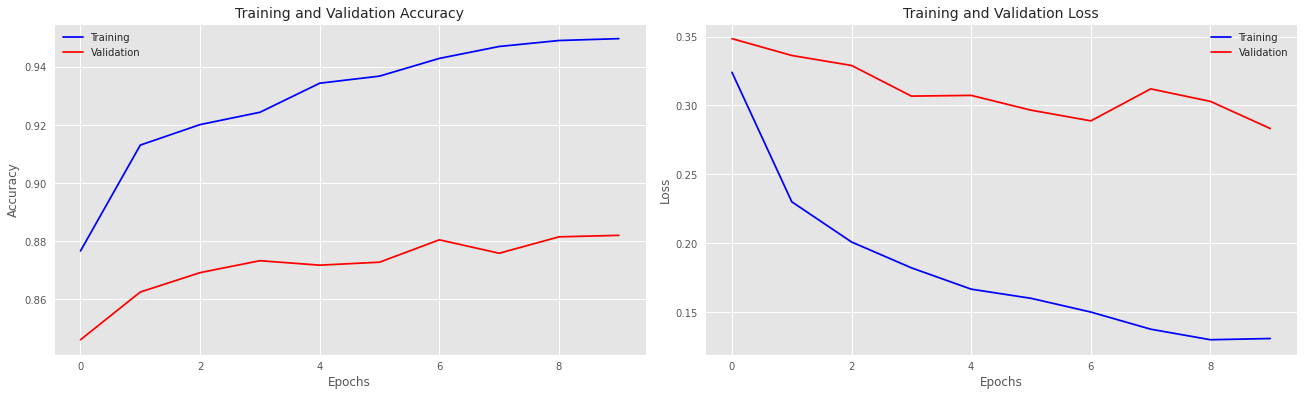

2021-12-16 12:06:36.892286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[900  75]
 [ 58 917]]
accuracy_score : 0.931795
precision_score : 0.924395
recall_score : 0.940513
f1 : 0.932384
auc : 0.9317948717948717


In [6]:
from tensorflow.keras.applications.xception import Xception
pre_trained_model_3 = Xception(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

training_main(pre_trained_model_3, "Xception", img_dim)

Epoch 1/10


2021-12-16 12:34:39.997631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - ETA: 0s - loss: 0.4335 - accuracy: 0.8521

2021-12-16 12:35:55.164899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - 90s 176ms/step - loss: 0.4335 - accuracy: 0.8521 - val_loss: 0.3989 - val_accuracy: 0.8349
Epoch 2/10
488/488 [==============================] - 79s 162ms/step - loss: 0.2636 - accuracy: 0.8974 - val_loss: 0.3683 - val_accuracy: 0.8544
Epoch 3/10
488/488 [==============================] - 85s 174ms/step - loss: 0.2288 - accuracy: 0.9044 - val_loss: 0.3402 - val_accuracy: 0.8646
Epoch 4/10
488/488 [==============================] - 93s 190ms/step - loss: 0.2095 - accuracy: 0.9133 - val_loss: 0.3425 - val_accuracy: 0.8636
Epoch 5/10
488/488 [==============================] - 100s 204ms/step - loss: 0.1917 - accuracy: 0.9229 - val_loss: 0.3141 - val_accuracy: 0.8821
Epoch 6/10
488/488 [==============================] - 98s 201ms/step - loss: 0.1832 - accuracy: 0.9287 - val_loss: 0.3147 - val_accuracy: 0.8810
Epoch 7/10
488/488 [==============================] - 103s 211ms/step - loss: 0.1742 - accuracy: 0.9308 - val_loss: 0.3046 - val_accuracy: 0

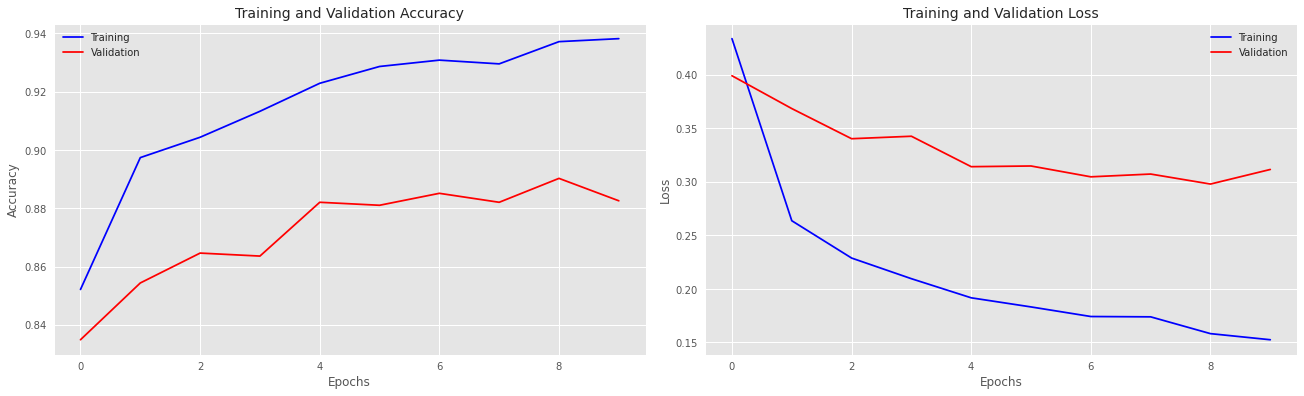

2021-12-16 12:50:16.327335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[854 121]
 [ 48 927]]
accuracy_score : 0.913333
precision_score : 0.884542
recall_score : 0.950769
f1 : 0.916461
auc : 0.9133333333333332


In [7]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
pre_trained_model_4 = ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

training_main(pre_trained_model_4, "ResNet152V2", img_dim)

Epoch 1/10


2021-12-16 12:59:24.169558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.8027

2021-12-16 13:00:02.704333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - 46s 89ms/step - loss: 0.4480 - accuracy: 0.8027 - val_loss: 0.4652 - val_accuracy: 0.8082
Epoch 2/10
488/488 [==============================] - 41s 84ms/step - loss: 0.3676 - accuracy: 0.8324 - val_loss: 0.4289 - val_accuracy: 0.8210
Epoch 3/10
488/488 [==============================] - 41s 84ms/step - loss: 0.3367 - accuracy: 0.8500 - val_loss: 0.4019 - val_accuracy: 0.8369
Epoch 4/10
488/488 [==============================] - 43s 87ms/step - loss: 0.3231 - accuracy: 0.8567 - val_loss: 0.3887 - val_accuracy: 0.8338
Epoch 5/10
488/488 [==============================] - 44s 89ms/step - loss: 0.3144 - accuracy: 0.8605 - val_loss: 0.3795 - val_accuracy: 0.8410
Epoch 6/10
488/488 [==============================] - 44s 91ms/step - loss: 0.2994 - accuracy: 0.8676 - val_loss: 0.3732 - val_accuracy: 0.8487
Epoch 7/10
488/488 [==============================] - 45s 91ms/step - loss: 0.2945 - accuracy: 0.8718 - val_loss: 0.3673 - val_accuracy: 0.8441
Epo

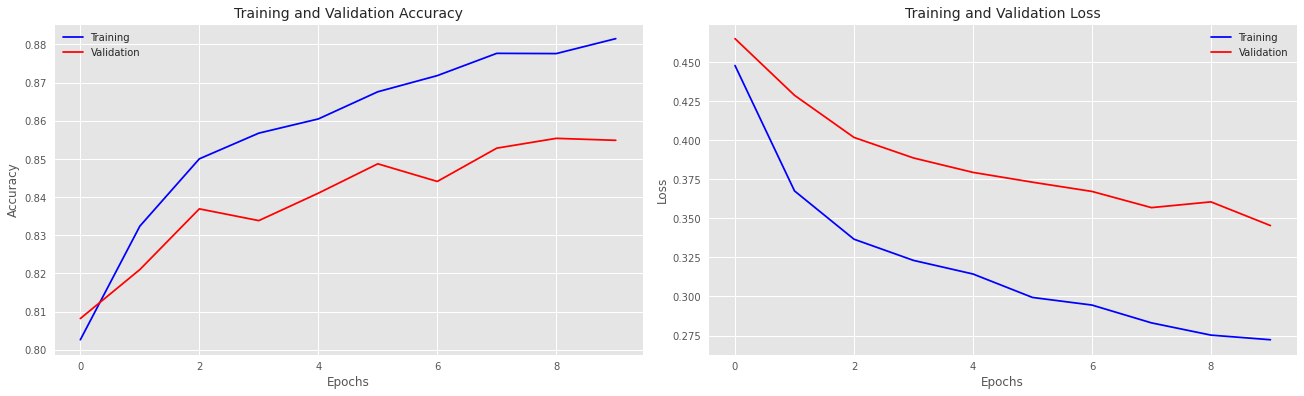

2021-12-16 13:06:43.740423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[875 100]
 [102 873]]
accuracy_score : 0.89641
precision_score : 0.897225
recall_score : 0.895385
f1 : 0.896304
auc : 0.8964102564102563


In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model_5 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

training_main(pre_trained_model_5, "InceptionV3", img_dim)

Epoch 1/10


2021-12-16 13:26:21.911745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8738

2021-12-16 13:27:13.999557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - 65s 123ms/step - loss: 0.3451 - accuracy: 0.8738 - val_loss: 0.3079 - val_accuracy: 0.8692
Epoch 2/10
488/488 [==============================] - 50s 102ms/step - loss: 0.2271 - accuracy: 0.9070 - val_loss: 0.2633 - val_accuracy: 0.8887
Epoch 3/10
488/488 [==============================] - 52s 107ms/step - loss: 0.2040 - accuracy: 0.9148 - val_loss: 0.2603 - val_accuracy: 0.8846
Epoch 4/10
488/488 [==============================] - 55s 113ms/step - loss: 0.1870 - accuracy: 0.9254 - val_loss: 0.2494 - val_accuracy: 0.8908
Epoch 5/10
488/488 [==============================] - 57s 117ms/step - loss: 0.1703 - accuracy: 0.9319 - val_loss: 0.2527 - val_accuracy: 0.8974
Epoch 6/10
488/488 [==============================] - 61s 125ms/step - loss: 0.1569 - accuracy: 0.9380 - val_loss: 0.2665 - val_accuracy: 0.8877
Epoch 7/10
488/488 [==============================] - 64s 130ms/step - loss: 0.1519 - accuracy: 0.9399 - val_loss: 0.2408 - val_accuracy: 0.8

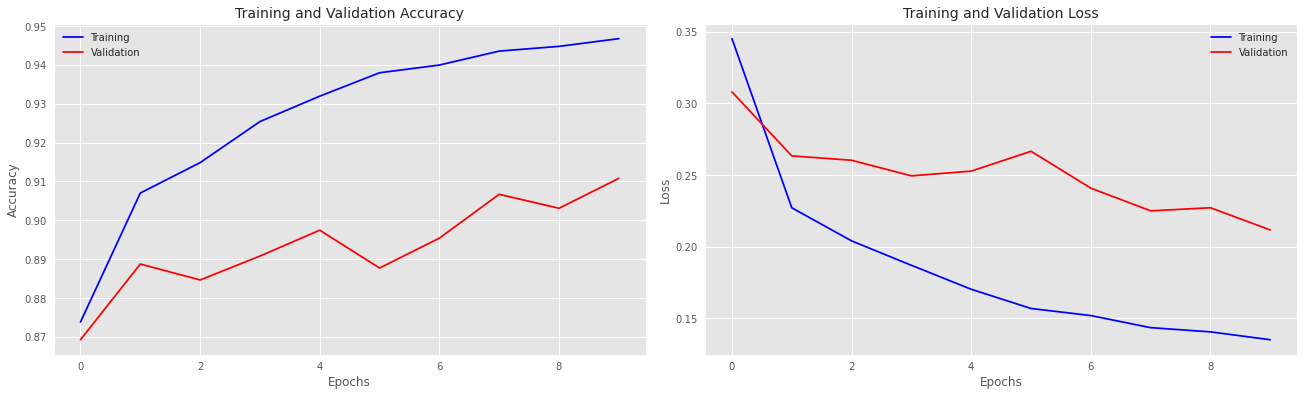

2021-12-16 13:36:17.557013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[920  55]
 [ 36 939]]
accuracy_score : 0.953333
precision_score : 0.944668
recall_score : 0.963077
f1 : 0.953784
auc : 0.9533333333333333


In [9]:
from tensorflow.keras.applications.densenet import DenseNet201
pre_trained_model_6 = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

training_main(pre_trained_model_6, "DenseNet201", img_dim)

Epoch 1/10


2021-12-16 13:55:59.343449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - ETA: 0s - loss: 0.4031 - accuracy: 0.8584

2021-12-16 13:56:52.912743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - 65s 127ms/step - loss: 0.4031 - accuracy: 0.8584 - val_loss: 0.3473 - val_accuracy: 0.8600
Epoch 2/10
488/488 [==============================] - 57s 116ms/step - loss: 0.2589 - accuracy: 0.8973 - val_loss: 0.3261 - val_accuracy: 0.8615
Epoch 3/10
488/488 [==============================] - 60s 122ms/step - loss: 0.2168 - accuracy: 0.9121 - val_loss: 0.3158 - val_accuracy: 0.8713
Epoch 4/10
488/488 [==============================] - 64s 132ms/step - loss: 0.2032 - accuracy: 0.9192 - val_loss: 0.3002 - val_accuracy: 0.8733
Epoch 5/10
488/488 [==============================] - 68s 138ms/step - loss: 0.1806 - accuracy: 0.9289 - val_loss: 0.2925 - val_accuracy: 0.8718
Epoch 6/10
488/488 [==============================] - 709s 1s/step - loss: 0.1701 - accuracy: 0.9315 - val_loss: 0.2728 - val_accuracy: 0.8779
Epoch 7/10
488/488 [==============================] - 57s 116ms/step - loss: 0.1694 - accuracy: 0.9335 - val_loss: 0.2833 - val_accuracy: 0.889

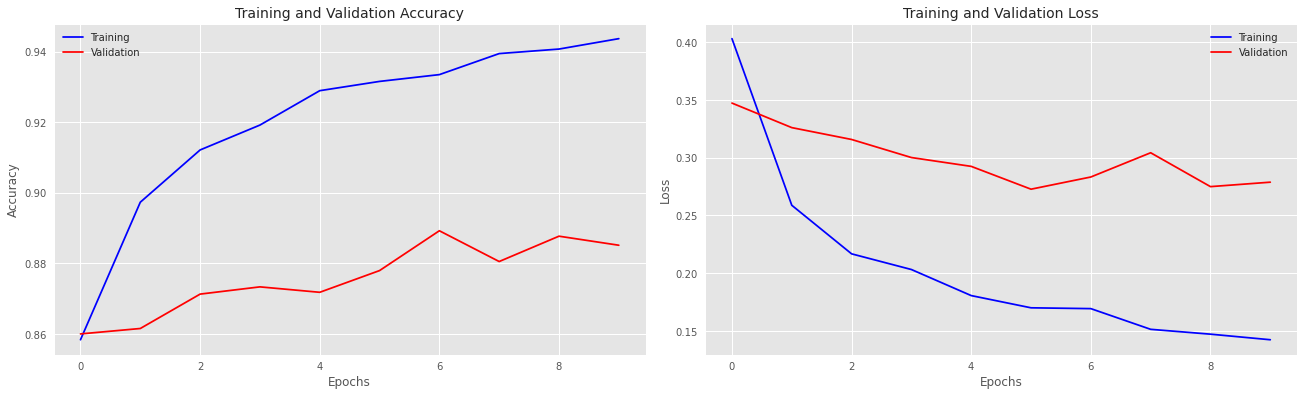

2021-12-16 14:17:09.057604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[879  96]
 [ 42 933]]
accuracy_score : 0.929231
precision_score : 0.906706
recall_score : 0.956923
f1 : 0.931138
auc : 0.9292307692307692


In [10]:
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
pre_trained_model_7 = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

training_main(pre_trained_model_7, "ResNet101V2", img_dim)

Epoch 1/10


2021-12-16 14:39:10.273410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.8285

2021-12-16 14:39:46.681211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - 42s 82ms/step - loss: 0.4619 - accuracy: 0.8285 - val_loss: 0.4535 - val_accuracy: 0.8097
Epoch 2/10
488/488 [==============================] - 37s 76ms/step - loss: 0.2712 - accuracy: 0.8851 - val_loss: 0.3719 - val_accuracy: 0.8379
Epoch 3/10
488/488 [==============================] - 38s 77ms/step - loss: 0.2434 - accuracy: 0.8974 - val_loss: 0.3416 - val_accuracy: 0.8492
Epoch 4/10
488/488 [==============================] - 37s 76ms/step - loss: 0.2328 - accuracy: 0.9030 - val_loss: 0.3558 - val_accuracy: 0.8554
Epoch 5/10
488/488 [==============================] - 37s 77ms/step - loss: 0.2176 - accuracy: 0.9082 - val_loss: 0.3279 - val_accuracy: 0.8585
Epoch 6/10
488/488 [==============================] - 38s 77ms/step - loss: 0.2083 - accuracy: 0.9126 - val_loss: 0.3639 - val_accuracy: 0.8585
Epoch 7/10
488/488 [==============================] - 38s 78ms/step - loss: 0.2007 - accuracy: 0.9161 - val_loss: 0.3295 - val_accuracy: 0.8656
Epo

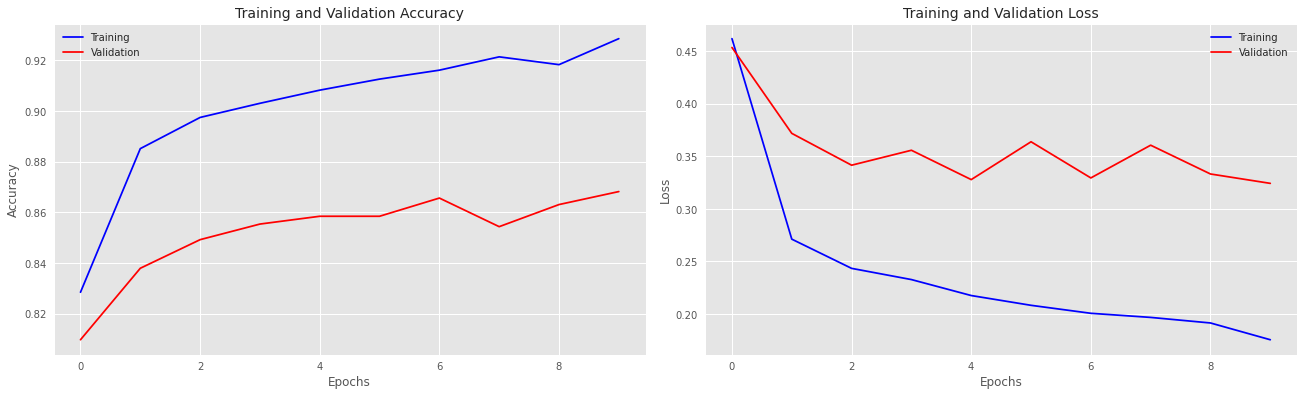

2021-12-16 15:05:19.179424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[866 109]
 [ 61 914]]
accuracy_score : 0.912821
precision_score : 0.893451
recall_score : 0.937436
f1 : 0.914915
auc : 0.9128205128205128


In [11]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
pre_trained_model_8 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

training_main(pre_trained_model_8, "MobileNetV2", img_dim)

Epoch 1/10


2021-12-16 15:22:05.889739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - ETA: 0s - loss: 0.4057 - accuracy: 0.8673

2021-12-16 15:22:44.842673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - 45s 88ms/step - loss: 0.4057 - accuracy: 0.8673 - val_loss: 0.3723 - val_accuracy: 0.8559
Epoch 2/10
488/488 [==============================] - 39s 80ms/step - loss: 0.2320 - accuracy: 0.9058 - val_loss: 0.3520 - val_accuracy: 0.8703
Epoch 3/10
488/488 [==============================] - 42s 85ms/step - loss: 0.2074 - accuracy: 0.9151 - val_loss: 0.3581 - val_accuracy: 0.8687
Epoch 4/10
488/488 [==============================] - 45s 92ms/step - loss: 0.1833 - accuracy: 0.9250 - val_loss: 0.3188 - val_accuracy: 0.8779
Epoch 5/10
488/488 [==============================] - 46s 95ms/step - loss: 0.1670 - accuracy: 0.9317 - val_loss: 0.3320 - val_accuracy: 0.8733
Epoch 6/10
488/488 [==============================] - 48s 97ms/step - loss: 0.1617 - accuracy: 0.9362 - val_loss: 0.3237 - val_accuracy: 0.8785
Epoch 7/10
488/488 [==============================] - 48s 99ms/step - loss: 0.1473 - accuracy: 0.9430 - val_loss: 0.3285 - val_accuracy: 0.8800
Epo

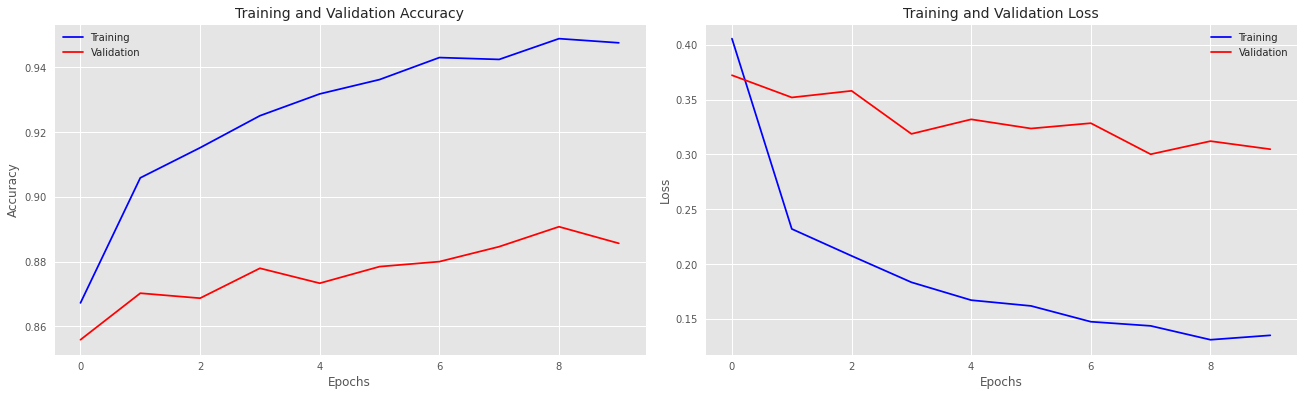

2021-12-16 15:43:46.311091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[854 121]
 [ 26 949]]
accuracy_score : 0.924615
precision_score : 0.886916
recall_score : 0.973333
f1 : 0.928117
auc : 0.9246153846153846


In [12]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
pre_trained_model_9 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

training_main(pre_trained_model_9, "ResNet50V2", img_dim)

Epoch 1/10


2021-12-16 15:48:35.526414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - ETA: 0s - loss: 0.4508 - accuracy: 0.7871

2021-12-16 15:49:18.246677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


488/488 [==============================] - 49s 98ms/step - loss: 0.4508 - accuracy: 0.7871 - val_loss: 0.5188 - val_accuracy: 0.7395
Epoch 2/10
488/488 [==============================] - 48s 99ms/step - loss: 0.3718 - accuracy: 0.8325 - val_loss: 0.6041 - val_accuracy: 0.7026
Epoch 3/10
488/488 [==============================] - 57s 116ms/step - loss: 0.3532 - accuracy: 0.8406 - val_loss: 0.5144 - val_accuracy: 0.7518
Epoch 4/10
488/488 [==============================] - 60s 124ms/step - loss: 0.3482 - accuracy: 0.8424 - val_loss: 0.4569 - val_accuracy: 0.7810
Epoch 5/10
488/488 [==============================] - 62s 128ms/step - loss: 0.3326 - accuracy: 0.8487 - val_loss: 0.4308 - val_accuracy: 0.7954
Epoch 6/10
488/488 [==============================] - 1014s 2s/step - loss: 0.3266 - accuracy: 0.8553 - val_loss: 0.5374 - val_accuracy: 0.7467
Epoch 7/10
488/488 [==============================] - 47s 97ms/step - loss: 0.3200 - accuracy: 0.8562 - val_loss: 0.5079 - val_accuracy: 0.7590


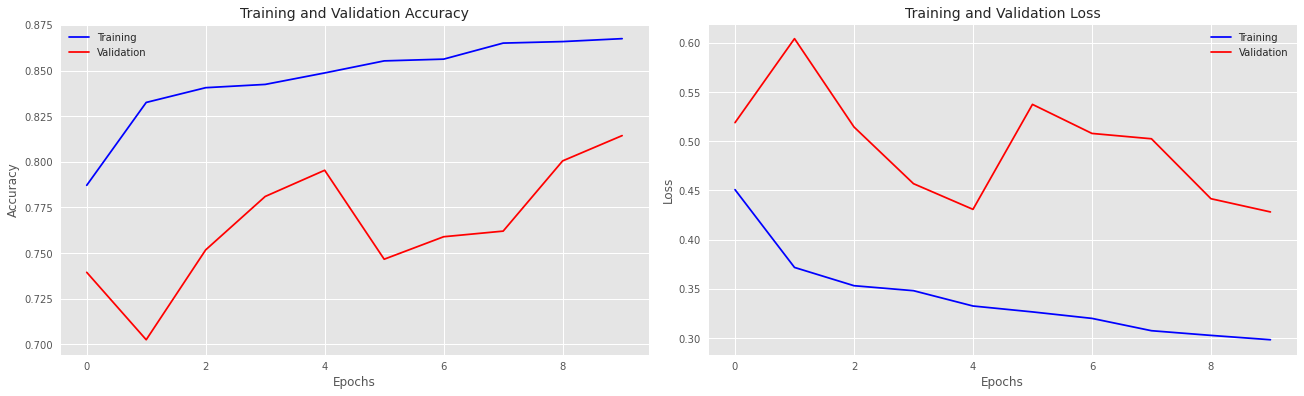

2021-12-16 16:13:33.937368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[875 100]
 [150 825]]
accuracy_score : 0.871795
precision_score : 0.891892
recall_score : 0.846154
f1 : 0.868421
auc : 0.8717948717948719


In [13]:
from tensorflow.keras.applications.vgg19 import VGG19
pre_trained_model_10 = VGG19(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))

training_main(pre_trained_model_10, "VGG19", img_dim)

In [42]:
labels = list(history_dict.keys())
train_metrics_col = ["Validation Accuracy", "Training Accuracy", "Validation Loss", "Training Loss"]

train_model_dict = dict()

for model_name in labels:
    train_acc = (history_dict[model_name].history["accuracy"])[-1]
    train_loss = (history_dict[model_name].history["loss"])[-1]
    val_accuracy = (history_dict[model_name].history["val_accuracy"])[-1]
    val_loss = (history_dict[model_name].history["val_loss"])[-1]
        
    train_model_dict[model_name] = [val_accuracy, train_acc, val_loss, train_loss]
    
train_metrics_df = pd.DataFrame(train_model_dict, index=train_metrics_col).transpose()
train_metrics_df = train_metrics_df.sort_values(by=["Validation Accuracy"], ascending=False)
display(train_metrics_df)

,Validation Accuracy,Training Accuracy,Validation Loss,Training Loss
DenseNet201,0.910769,0.946738,0.211645,0.135072
DenseNet121,0.896410,0.937508,0.259388,0.153512
ResNet50V2,0.885641,0.947507,0.304795,0.134884
ResNet101V2,0.885128,0.943661,0.278849,0.142416
ResNet152V2,0.882564,0.938213,0.311463,0.152564
Xception,0.882051,0.949686,0.283281,0.130995
MobileNetV2,0.868205,0.928535,0.324300,0.175552
InceptionResNetV2,0.855385,0.899756,0.347802,0.231079
InceptionV3,0.854872,0.881490,0.345442,0.272296
VGG19,0.814359,0.867453,0.428155,0.298346


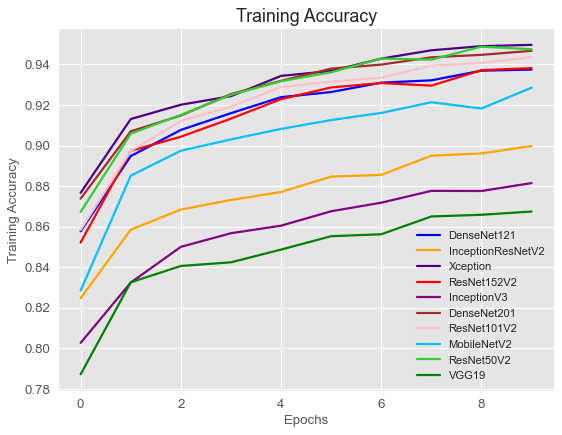

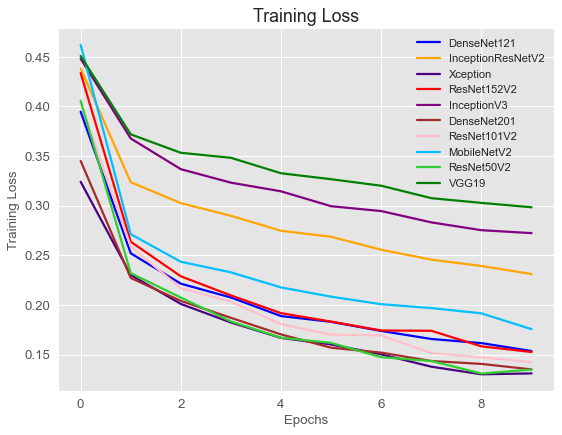

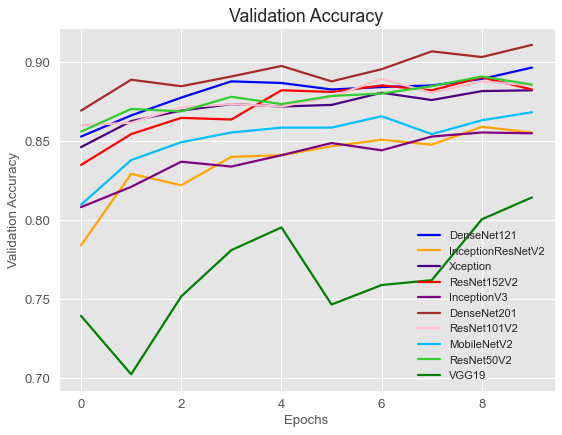

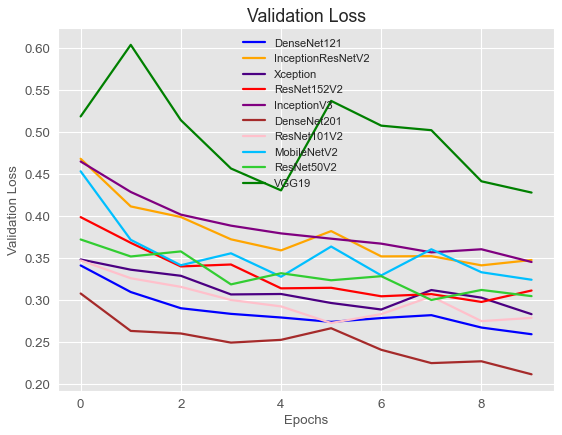

In [47]:
def return_title(metric):
    if metric == "accuracy":
        return "Training Accuracy"
    elif metric == "loss":
        return "Training Loss"
    elif metric == "val_accuracy":
        return "Validation Accuracy"
    elif metric == "val_loss":
        return "Validation Loss"


for metric in ["accuracy", "loss", "val_accuracy", "val_loss"]:
    
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(figsize=(8,6), dpi=80)
        
        colors = ["blue", "orange", "indigo", "red", "purple", "brown", "pink", "deepskyblue", "limegreen", "green"]
        labels = list(history_dict.keys()) 
        
        for i in range(0, 10):
            plt.plot(history_dict[labels[i]].history[metric], 
                     color=colors[i], 
                     label=labels[i], 
                     linewidth=2)
        
        plt.title(return_title(metric), fontsize=16)
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel(return_title(metric), fontsize=12)
        plt.legend(fontsize=10)
        plt.minorticks_on()
        
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        plt.grid(color='w', linestyle='solid')
        plt.show()


In [17]:
metric_col = ["Accuracy", "Precision", "Recall", "F1-score", "AUC"]
results_df = pd.DataFrame(result_dict, index=metric_col).transpose()
results_df = results_df.sort_values(by=["AUC"], ascending=False)
display(results_df)

,Accuracy,Precision,Recall,F1-score,AUC
DenseNet201,0.953333,0.944668,0.963077,0.953784,0.953333
Xception,0.931795,0.924395,0.940513,0.932384,0.931795
DenseNet121,0.931282,0.916749,0.948718,0.932460,0.931282
ResNet101V2,0.929231,0.906706,0.956923,0.931138,0.929231
ResNet50V2,0.924615,0.886916,0.973333,0.928117,0.924615
ResNet152V2,0.913333,0.884542,0.950769,0.916461,0.913333
MobileNetV2,0.912821,0.893451,0.937436,0.914915,0.912821
InceptionV3,0.896410,0.897225,0.895385,0.896304,0.896410
InceptionResNetV2,0.895897,0.858736,0.947692,0.901024,0.895897
VGG19,0.871795,0.891892,0.846154,0.868421,0.871795


<Figure size 1296x720 with 0 Axes>

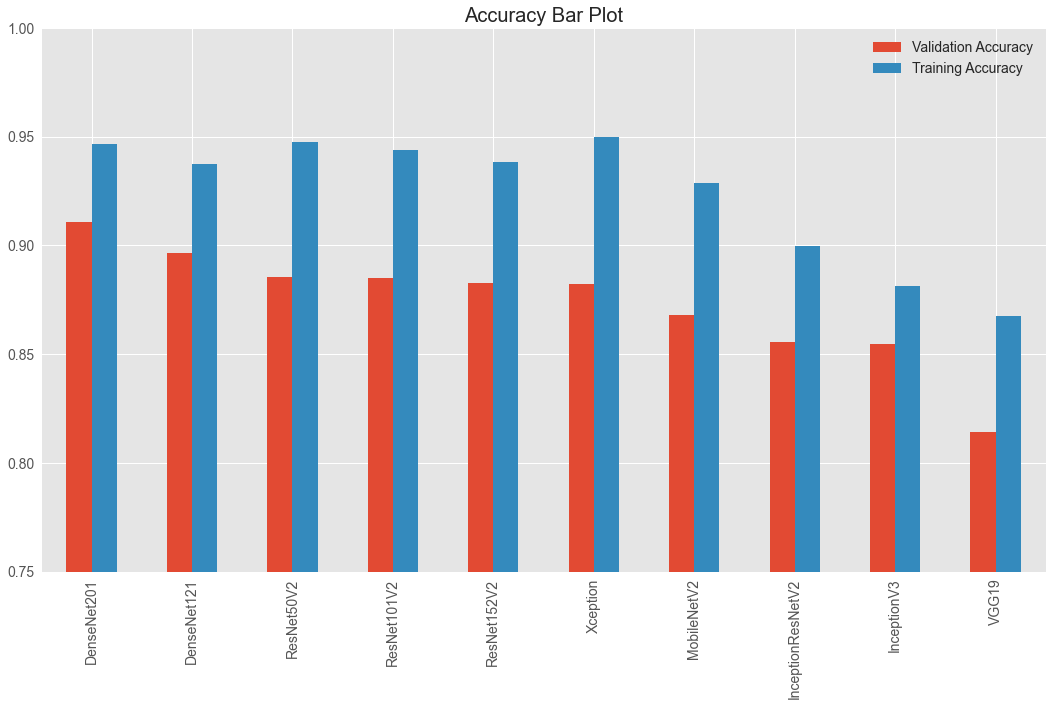

<Figure size 1296x720 with 0 Axes>

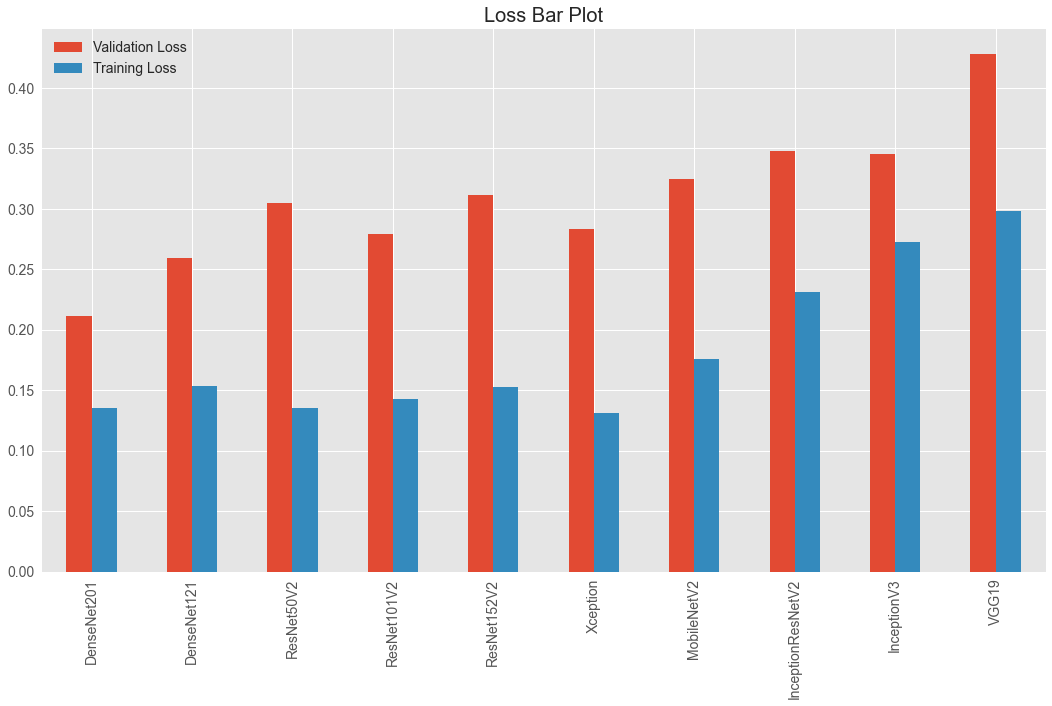

In [22]:
with plt.style.context(("seaborn","ggplot")):
    fig = plt.figure(constrained_layout=True, figsize=(18,10))

    train_metrics_df[["Validation Accuracy", "Training Accuracy"]].plot.bar(figsize=(18,10))

    plt.title("Accuracy Bar Plot", fontsize=20)
    plt.legend(fontsize=14)
    plt.minorticks_on()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0.75, 1)
    plt.grid(color='w', linestyle='solid')
    plt.show()
        
with plt.style.context(("seaborn","ggplot")):
    fig = plt.figure(constrained_layout=True, figsize=(18,10))

    train_metrics_df[["Validation Loss", "Training Loss"]].plot.bar(figsize=(18,10))

    plt.title("Loss Bar Plot", fontsize=20)
    plt.legend(fontsize=14)
    plt.minorticks_on()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(color='w', linestyle='solid')
    plt.show()

  